### Import

In [1]:
from datetime import datetime
import functools
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
from PIL import ImageEnhance
import random

### Target Image Parameters

In [2]:
target_width = 72
target_height = 48
operation = "euclidean" 

target_path = "../input/IMG_4726.jpg"
output_path = "../output/"

### Replacement Image Parameters

In [3]:
replacement_width = 50
replacement_height = 50
# proximity = 10
frequency = 5
max_number_of_uses = 10
max_saturation_adjustment = 2
min_saturation_adjustment = 0.6
brightness_adjustment = 0.15
# kernel_size = 1

replacement_path = "../replacement"

### Pixel Image

In [4]:
class PixelImage:
    _resolution = (50, 50) # (width, height)
    _min_saturation_adjust = 1 # does not effect image
    _max_saturation_adjust = 1 # does not effect image
    _brightness_adjust = 0 # does not effect image
    _max_number_of_uses = 100000 # too many to worry about
    _operation = "euclidean"
    
    def __init__(self, image):
        self._image_key = 0
        self._image = image  
        self._process_image()
        self.last_used_count = -100 # initialized value
        self.number_of_uses = PixelImage._max_number_of_uses
    
    @classmethod
    def load_parameters(self, width=None, height=None, min_saturation_adjust=None, max_saturation_adjust=None, 
                        brightness_adjust=None, max_number_of_uses=None, operation=None):
        if width is not None and height is not None:
            PixelImage._resolution = (width, height)
        if min_saturation_adjust is not None and max_saturation_adjust is not None:
            PixelImage._min_saturation_adjust = min_saturation_adjust
            PixelImage._max_saturation_adjust = max_saturation_adjust
        if brightness_adjust is not None:
            PixelImage._brightness_adjust = brightness_adjust
        if max_number_of_uses is not None:
            PixelImage._max_number_of_uses = max_number_of_uses
        if operation is not None:
            PixelImage._operation = operation
        
    def key_compare(self, pixel):
        if (self._operation == "euclidean"):
            return np.linalg.norm(self._image_key - pixel)
        
    def display(self, is_getting_default=True):
        if is_getting_default:
            plt.imshow(self._image)
        else:
            plt.imshow(self.get_image())
        
    def get_image(self, is_getting_default=False):
        if is_getting_default:
            return self._image
        else:
            # adjust saturation # TODO: this should probably come after the brightness tbh
            saturation_adjust = random.uniform(self._min_saturation_adjust, self._max_saturation_adjust)
            converter = ImageEnhance.Color(Image.fromarray(self._image))
            img = converter.enhance(saturation_adjust)
            
            # adjust brightness
            brightness_adjust = 1 + random.uniform(-self._brightness_adjust, self._brightness_adjust)
            return np.clip((np.array(img) * brightness_adjust) / 255, 0, 1)
        
    def _process_image(self):
        self._image = self._image_transpose_exif(self._image)
        self._image = self._image.resize(self._resolution)
        try:
            self._image = np.array(self._image)[:, :, 0:3]
            self._image_key = self._prepare_key(self._image)
        except:
            print("image failed to load") # TODO: handle black and white images
            self._image = np.array(self._image)
            self._image_key = self._prepare_key(self._image)
        
    @staticmethod
    def _image_transpose_exif(im):
        """
        Apply Image.transpose to ensure 0th row of pixels is at the visual
        top of the image, and 0th column is the visual left-hand side.
        Return the original image if unable to determine the orientation.

        As per CIPA DC-008-2012, the orientation field contains an integer,
        1 through 8. Other values are reserved.

        Parameters
        ----------
        im: PIL.Image
           The image to be rotated.
        """

        exif_orientation_tag = 0x0112
        exif_transpose_sequences = [                   # Val  0th row  0th col
            [],                                        #  0    (reserved)
            [],                                        #  1   top      left
            [Image.FLIP_LEFT_RIGHT],                   #  2   top      right
            [Image.ROTATE_180],                        #  3   bottom   right
            [Image.FLIP_TOP_BOTTOM],                   #  4   bottom   left
            [Image.FLIP_LEFT_RIGHT, Image.ROTATE_90],  #  5   left     top
            [Image.ROTATE_270],                        #  6   right    top
            [Image.FLIP_TOP_BOTTOM, Image.ROTATE_90],  #  7   right    bottom
            [Image.ROTATE_90],                         #  8   left     bottom
        ]

        try:
            seq = exif_transpose_sequences[im._getexif()[exif_orientation_tag]]
        except Exception:
            return im
        else:
            return functools.reduce(type(im).transpose, seq, im)
        
    @classmethod
    def _prepare_key(self, image):
        if (self._operation == "euclidean"):
            return self._euclidean(image)
    
    @staticmethod
    def _euclidean(image):
        image_key = np.array([0, 0, 0])
        for band in image:
            for pixel in band:
                try:
                    image_key += pixel[0:3]
                except:
                    image_key += np.array([pixel, pixel, pixel]) # TODO: handle black and white images
        return image_key / (image.shape[0] * image.shape[1])
            

In [5]:
PixelImage.load_parameters(width=replacement_width, 
                           height=replacement_height, 
                           min_saturation_adjust=min_saturation_adjustment, 
                           max_saturation_adjust=max_saturation_adjustment, 
                           brightness_adjust=brightness_adjustment, 
                           max_number_of_uses=max_number_of_uses,
                           operation=operation)

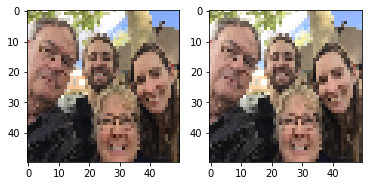

In [6]:
default_image = Image.open(target_path)
p1 = PixelImage(default_image)
plt.subplot(1, 2, 1)
p1.display()
plt.subplot(1, 2, 2)
p1.display(is_getting_default=False)

### Pixelator

In [7]:
class Pixelator:
    def __init__(self):
        self._white_list_file_types = ['png', 'jpg', 'jpeg', 'bmp', 'ppm']
        self._resolution = (60, 40) # (width, height)
        self._frequency = 0
        self._replacement_images = []
        self._target_image = None
        self._target_image_key = 0
        self.output_image = None
        
    def load_parameters(self, width=None, height=None, white_list_file_types=None, frequency=None):
        if width is not None and height is not None:
            self._resolution = (width, height)
        if white_list_file_types is not None:
            self._white_list_file_types = white_list_file_types
        if frequency is not None:
            self._frequency = frequency
    
    def load_replacement_images(self, path):
        print("loading replacement images...", end =" ") 
        self.path, directories, files = next(os.walk(path))
        for i in range(len(files)):
            self._attempt_append_image(files[i])
        print("done")
        
    def plot_gallery_for_replacement_images(self, img_size=None, is_random=True, n_row=3, n_col=6):
        print("plotting replacement images...", end =" ") 
        plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
        plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
        for i in range(n_row * n_col):
            plt.subplot(n_row, n_col, i + 1)
            if is_random:
                index = random.randint(0, len(self._replacement_images) - 1)
            else:
                index = i
            plt.imshow(self._replacement_images[index].get_image(is_getting_default=True))
            plt.xticks(())
            plt.yticks(())
        print("done") 
        
    def photo_pixelate_target_image(self, target_path):
        list_of_pixel_images = []
        self._target_image = Image.open(target_path)
        self._process_target_image()
        print("target image shape is " + str(self._target_image.shape))
        print("pixelating target image...", end =" ") 
        count = 0
        for band in self._target_image:
            for pixel in band:
                count += 1
                list_of_pixel_images.append(self._get_closest_image(pixel, count))
        self._convert_output_to_image(list_of_pixel_images)
        print("done")
        
    def display(self):
        print("displaying output image...", end =" ") 
        if self.output_image is not None:
            plt.imshow(self.output_image)
        print("done")
        
    def save(self, filename=None):
        print("saving output image...", end =" ") 
        pil_image = Image.fromarray(np.uint8(self.output_image * 255))
        if filename is None:
            pil_image.save("output.png")
        else:
            pil_image.save(filename)
        print("done")
    
    def _attempt_append_image(self, file_name):
        for file_type in self._white_list_file_types: 
            if file_type.upper() in file_name.upper():
                image_file_path = self.path + '/' + file_name
                image = Image.open(image_file_path)
                pixel_image = PixelImage(image)
                self._replacement_images.append(pixel_image)
                
    def _process_target_image(self):
        self._target_image = self._target_image.resize(self._resolution)
        self._target_image = np.array(self._target_image)
                
    def _get_closest_image(self, pixel, count):
        closest_index = 0
        closest_image = None
        closest_value = 1000000 # ridiculously large number
        for i in range(len(self._replacement_images)):
            pixel_image = self._replacement_images[i]
            value = pixel_image.key_compare(pixel)
            # HACK: this line is way too long
            if value < closest_value and count > self._frequency + pixel_image.last_used_count and pixel_image.number_of_uses > 0:
                closest_image = pixel_image
                closest_value = value
                closest_index = i
        self._replacement_images[closest_index].last_used_count = count
        self._replacement_images[closest_index].number_of_uses -= 1
        return closest_image

    def _convert_output_to_image(self, list_of_pixel_images):
        self.output_image = None
        for r in range(self._resolution[1]):
            band_of_images = None
            for c in range(self._resolution[0]):
                image = list_of_pixel_images[r * self._resolution[0] + c].get_image()
#                 image = list_of_pixel_images[r * self._resolution[0] + c].get_image(is_getting_default=True)
                if band_of_images is None:
                    band_of_images = image
                else:
                    band_of_images = np.concatenate((band_of_images, image), axis=1)
            if self.output_image is None:
                self.output_image = band_of_images
            else:
                self.output_image = np.concatenate((self.output_image, band_of_images), axis=0)
        

### Loading Replacement Images

In [8]:
%%time
pixelator = Pixelator()
pixelator.load_parameters(width=target_width, height=target_height, frequency=frequency)
pixelator.load_replacement_images(replacement_path)

loading replacement images... done
CPU times: user 1min 29s, sys: 3.22 s, total: 1min 32s
Wall time: 1min 33s


plotting replacement images... done
CPU times: user 185 ms, sys: 5.5 ms, total: 190 ms
Wall time: 189 ms


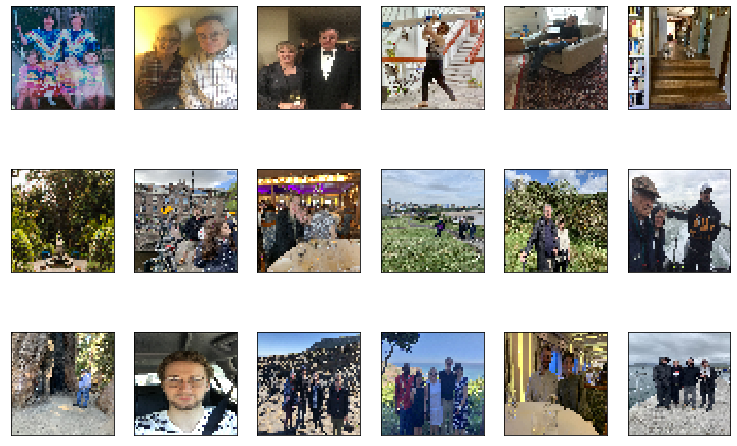

In [9]:
%%time
pixelator.plot_gallery_for_replacement_images()

### Creating an Image of Images

target image shape is (48, 72, 3)
pixelating target image... done
displaying output image... done
CPU times: user 37.2 s, sys: 6.78 s, total: 44 s
Wall time: 22.6 s


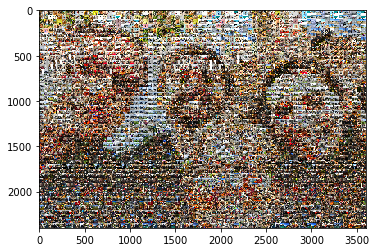

In [10]:
%%time
pixelator.photo_pixelate_target_image(target_path)
pixelator.display()

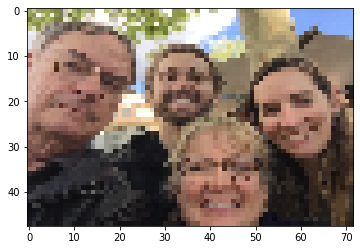

In [11]:
pil_image = Image.open(target_path)
pil_image = pil_image.resize((target_width, target_height))
plt.imshow(pil_image)

### Saving Output

In [12]:
%%time
now = datetime.now() # current date and time
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
filename = date_time.replace('/','|').replace(':','-') + ".png"
pixelator.save(filename=output_path + filename)
# pixelator.save()

saving output image... done
CPU times: user 1.54 s, sys: 100 ms, total: 1.64 s
Wall time: 1.67 s
